In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from pprint import pprint
import time
import os
from scipy.stats import linregress
from citipy import citipy
from api_keys import weather_api_key

In [2]:
DEBUG = False
def watch(x):
    if DEBUG:
        pprint(x)

In [3]:
def get_random_cities(northern=True):
    # Range of latitudes and longitudes
    lat_range = (0, 90) if northern else (-90, 0)
    lng_range = (-180, 180)

    # List for holding lat_lngs and cities
    lat_lngs = []
    cities = set()

    # Create a set of random lat and lng combinations
    lats = np.random.uniform(lat_range[0], lat_range[1], size=750)
    lngs = np.random.uniform(lng_range[0], lng_range[1], size=750)

    # Identify nearest city for each lat, lng combination
    for lat, lng in zip(lats, lngs):
        cities.add(citipy.nearest_city(lat, lng).city_name)

    # Print the city count to confirm sufficient count
    print(len(cities))
    return cities

In [4]:
def get_weather_data(cities):
    weather_data = []
    for city in cities:
        watch(f"http://api.openweathermap.org/data/2.5/weather?appid={weather_api_key}&q={city}&units=imperial")
        raw_weather_data = requests.get(f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={weather_api_key}&units=imperial").json()
        watch(raw_weather_data)
        if int(raw_weather_data['cod']) == 200:
            if int(raw_weather_data['main']['humidity']) > 100:
                watch('Not OK')
                continue
            watch('OK')
            weather_data.append({
                'City' : raw_weather_data['name'],
                'Lat' : raw_weather_data['coord']['lat'],
                'Lng' : raw_weather_data['coord']['lon'],
                'Max Temp' : raw_weather_data['main']['temp_max'],
                'Humidity' : raw_weather_data['main']['humidity'],
                'Cloudiness' : raw_weather_data['clouds']['all'],
                'Wind Speed' : raw_weather_data['wind']['speed'],
                'Country' : raw_weather_data['sys']['country'],
                'Date' : raw_weather_data['dt']
            })
            print(f'\r {len(weather_data)}. {city}', end='')
        else:
            watch(f"error {raw_weather_data['cod']}")
    print()
    return weather_data

In [5]:
weather_df = {'N' : None, 'S' : None}
for h in weather_df:
    cities = get_random_cities(h == 'N')
    weather_data = get_weather_data(cities)
    weather_df[h] = pd.DataFrame(weather_data)
    weather_df[h].head()

437
 392. aransas pass
207
 190. mogadishu


In [6]:
for h in weather_df:
    watch(weather_df[h])
    os.makedirs('output_data', exist_ok=True)
    weather_df[h].to_csv(f'output_data/cities_{h}.csv', index=False)

In [7]:
# read the cities_{h}.csv to create weather dataframe, previous cells are not needed to be executed as long as cities_{h}.csv was created
weather_df = {
    'N' : pd.read_csv('output_data/cities_N.csv'),
    'S' : pd.read_csv('output_data/cities_S.csv')
}

In [8]:
def scatter_plot(x_label, y_label, y_eqn):
    weather_df[h].plot(kind='scatter', x=x_label, y=y_label)
    plt.savefig(f'output_data/{h}_lat_vs_{y_label.split()[0]}.png')
    x = weather_df[h][x_label].to_numpy().reshape(-1, 1)
    slope, intercept, rvalue, pvalue, stderr = y_eqn
    line_eq = f'y = {round(slope, 2)}x + {round(intercept,2)}'
    y_pred = x * slope + intercept
    plt.plot(x, y_pred, color='red')
    plt.annotate(line_eq, (0, intercept+2), fontsize=15, color='red')
    plt.savefig(f'output_data/{h}_lat_vs_{y_label.split()[0]}_regres.png')

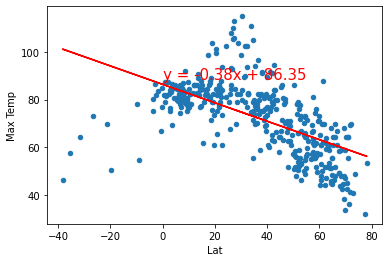

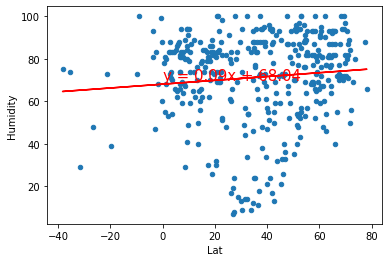

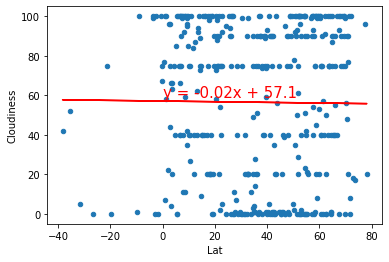

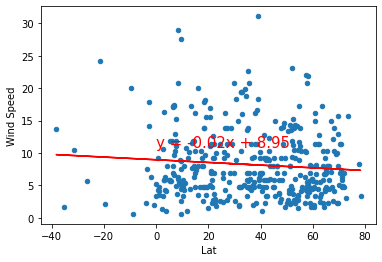

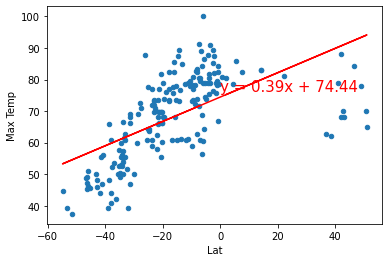

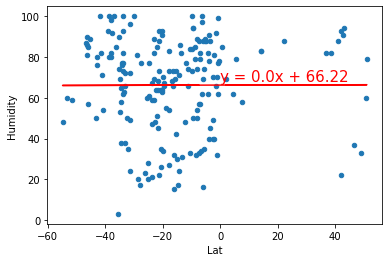

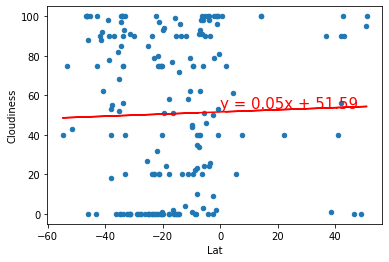

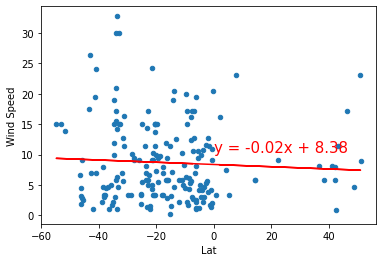

In [9]:
plot_pairs = [('Lat', 'Max Temp'), ('Lat', 'Humidity'), ('Lat', 'Cloudiness'), ('Lat', 'Wind Speed')]
for h in weather_df:
    predictions = [linregress(weather_df[h][x], weather_df[h][y]) for x, y in plot_pairs]
    for labels, y_pred in zip(plot_pairs, predictions):
        scatter_plot(labels[0], labels[1], y_pred)
        plt.show()

# Observations

1. As expected, temperature correlates well with the latitude. As latitude moves away from equator, temperature also decreases

2. It seems that there is no correlation between humidity and latitude

3. Even though there is very little correlation between wind speed and latitude, wind speed tends to be higher near arctic and antarctic